# Atlas notebooks

***

> This notebook reproduces and extends parts of the regional figures of the AR6-WGI Atlas chapter. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes.

## Computing and visualization of precipitation linear trends during the observed period (1980-2014)

07/07/2021

**J. Baño-Medina** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

We present an illustrative example to use the Atlas hub and the climate4R framework to depict the observed linear trends and the anomalies time series of precipitation over North America, over a selected time period for the EWEMBI observational dataset. Indications are also provided to apply the methodology to other variables, such as temperature.

### Load packages

The notebok relies on several climate4R packages:

In [1]:
options(java.parameters = "-Xmx8g") # extends Java (loadeR) memory allocation
library(loadeR)
library(transformeR)
library(visualizeR) # spatialPlot
library(geoprocessoR)
library(climate4R.indices) # linearTrend

Loading required package: rJava
Loading required package: loadeR.java
Java version 11x amd64 by Oracle Corporation detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
climate4R.UDG version 0.2.0 (2020-07-31) is loaded
Get the latest stable version (0.2.3) using <devtools::install_github('SantanderMetGroup/climate4R.UDG')>
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.7.0 (2020-09-18) is loaded
Get the latest stable version (1.7.1) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>
Please use 'citation("loadeR")' to cite this package.



    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.0 (2021-03-17) is loaded
Get the latest stable version (2.1.2) using <devtools::install_github('SantanderMetGroup/transformeR')>
Please see 'citation("transformeR")' to cite this package.
visualizeR version 1.6.0 (2020-05-23) is loaded
Get the latest stable version (1.6.1) using <devtools::install_github('SantanderMetGroup/visualizeR')>
Please see 'citation("visualizeR")' to cite this package.
geoprocessoR version 0.2.0 (2020-01-06) is loaded
Please see 'citation("geoprocessoR")' to cite this package.
climate4R.indices version 0.2.0 (2021-07-08) is loaded
Use 'indexShow()' for an overview of the available climate indices and circIndexShow() for the circulation indices.
NOTE: use package climate4R.climdex to calculate ETCCDI indices.

Attaching package: ‘climate4R.indices’

The following object is masked from ‘package:transformeR’:

    lambWT



Along with other libraries, namely:

 * `magrittr` is used to pipe (%>%) sequences of data operations
 * `gridExtra` provides plotting functionalities
 * `sp` and `rgdal` provide geospatial tools
 * `RColorBrewer` provides color palettes

In [2]:
library(magrittr)
library(gridExtra)
library(sp)
library(RColorBrewer)
library(rgdal) # readOGR

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.2, released 2021/03/05
Path to GDAL shared files: /home/chus/usr/miniconda3/envs/c4r/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.0, March 1st, 2021, [PJ_VERSION: 800]
Path to PROJ shared files: /home/chus/usr/miniconda3/envs/c4r/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.


### Set parameters
We can tune these parameters to define characteristics of the data to be loaded (e.g., variable to process, domain boundaries, temporal period)

In [3]:
var <- "pr"
latLim <- c(12,74)
lonLim <- c(-170,-50)
years <- 1980:2014

You can find out other variable names by issuing `C4R.vocabulary()`.

The following setting control the plots below. They define colorbar ranges and, thus, depend on the variable units.

In [4]:
colorScale_climatology <- seq(0, 10, 1)
colorScale_trends <- seq(-0.1, 0.1, 0.01)
ylim_anom <- c(-1,1)

### Load static data

We will load the boundaries of the IPCC [reference regions](../reference-regions) v4:

In [5]:
regs <- get(load("../reference-regions/IPCC-WGI-reference-regions-v4_R.rda")) %>% as("SpatialPolygons")
regs.area <- c("NWN", "NEN", "WNA", "CNA","ENA","NCA","SCA","CAR") # North America regions

We load also the coastlines, to be used in the spatial maps below. These are available in the [auxiliary-material](./auxiliary-material) folder:

In [6]:
coast <- readOGR("auxiliary-material/WORLD_coastline.shp") 

OGR data source with driver: ESRI Shapefile 
Source: "/home/chus/zzgit/IPCC-WG1/Atlas/notebooks/auxiliary-material/WORLD_coastline.shp", layer: "WORLD_coastline"
with 127 features
It has 2 fields


### Load observations from the User Data Gateway

To load data stored in the User Data Gateway (similar to loading data from a local directory), we rely on the C4R library called `climate4R.UDG`, that contains 2 main functions: `UDG.datasets` and `loadGridData`.

Note that you should have a working UDG account in order for these code chunks to work. See the next section ([Load data from file](#Load-data-from-file)) to load these data from a local copy available in the repository.

On the one hand, `UDG.datasets` lists all the datasets accessible from the UDG.

In [7]:
library(climate4R.UDG)
UDG.datasets("obs")

Matches found for: OBSERVATIONS
Label names are returned, set argument full.info = TRUE to get more information


$OBSERVATIONS
[1] "PIK_Obs-EWEMBI"        "E-OBS_v14_0.50regular" "E-OBS_v14_0.44rotated"
[4] "E-OBS_v14_0.25regular" "E-OBS_v14_0.22rotated" "E-OBS_v17_0.50regular"
[7] "E-OBS_v17_0.44rotated" "E-OBS_v17_0.25regular" "E-OBS_v17_0.22rotated"

```
loginUDG("user","password")
```

We see how, to-date, only EWEMBI and E-OBS datasets are available from the UDG (more coming). For example, to load EWEMBI we just input the corresponding label to the `dataset` argument in `loadGridData`. We load them year by year in the following loop to save memory. We end up with a dataset (a climate4R Grid object) containing yearly averages for the region selected. The following piece of code takes about 1 minute per year loaded (depends on your network connection speed).

```
grid.list <- list()
for (year in years){
    message(" ** Reading year ", year)
    grid.list[[as.character(year)]] <- loadGridData(
        dataset = "PIK_Obs-EWEMBI", var = var,
        latLim = latLim, lonLim = lonLim, years = year
    ) %>%
    aggregateGrid(aggr.y = list(FUN = "mean", na.rm = TRUE)) 
}
grid <- bindGrid(grid.list, dimension = "time")                                         
attr(grid$xyCoords, "projection") <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"  
```

These data took long to generate. We could save them for later use (see next section) by issuing

```
save(grid, file="auxiliary-material/EWEMBI-NorthAmerica-pr-yearly.rda")
```

### Load data from file

Skip this section if you sucessfully loaded your data from the User Data Gateway. For a fast loading of the required data, you can use a copy of the yearly averaged precipitation available in the `auxiliary-material` folder:

In [8]:
grid <- get(load("auxiliary-material/EWEMBI-NorthAmerica-pr-yearly.rda"))

### Working with the data loaded

We define the geographical projection.

In [9]:
proj4string(regs) <- CRS(attr(grid$xyCoords,"projection"))

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in proj4string(obj):
“CRS object has comment, which is lost in output”Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +ellps=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”

We compute the climatology by calling the `climatology` function and then use `spatialPlot` from library `visualizeR` to depict it. We introduce the IPCC regions of interest in the `sp.layout` argument.

[2021-07-09 11:52:53] - Computing climatology...
[2021-07-09 11:52:53] - Done.


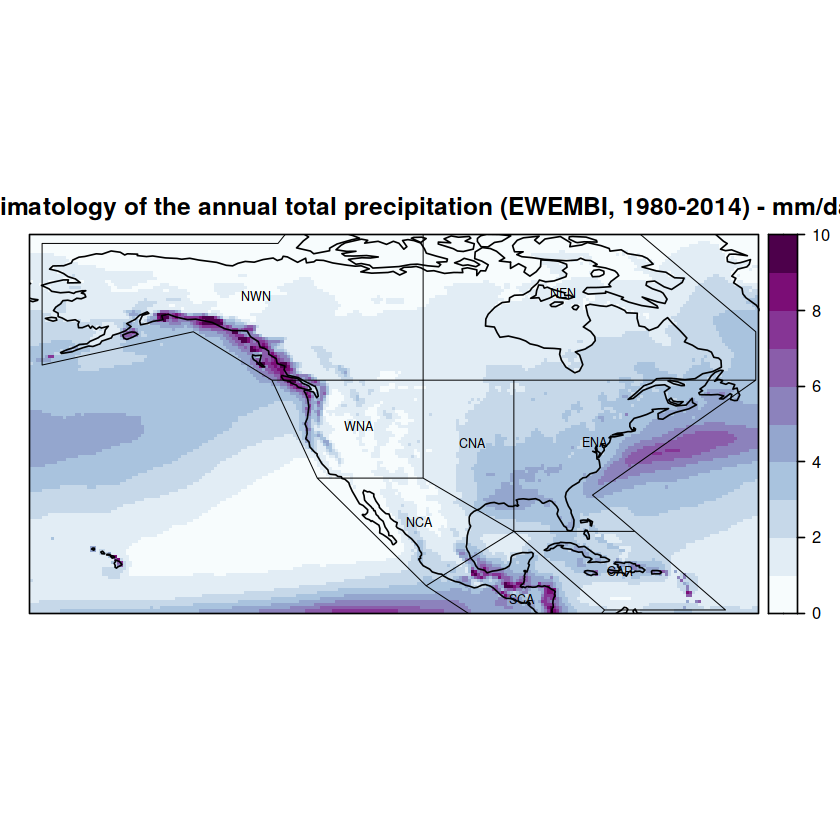

In [10]:
spatialPlot(climatology(grid),
            at = colorScale_climatology, 
            set.min = colorScale_climatology[1],
            set.max = colorScale_climatology[length(colorScale_climatology)],
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste("Climatology of the annual total precipitation (EWEMBI, 1980-2014) - mm/day"),
            sp.layout = list(
                list(regs[regs.area], first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

We call the function `linearTrend` that computes the linear points at gridbox level and returns all the involved statistics (e.g., p-value of the estimated slope). We subset the slope ("b") among all the statistics returned, by calling `subsetGrid`. 

In [11]:
trendGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "b")

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.
[2021-07-09 11:52:55] - Computing climatology...
[2021-07-09 11:52:55] - Done.
Warning message:
“Only one grid passed as input. Nothing was done”

We could save this climate products as NetCDF files using `loader.2nc` C4R library.

```
library(loadeR.2nc)
grid2nc(trendGrid, NetCDFOutFile = "trends.nc4")
```

We call the function `overGrid` that overlaps the trends object with the IPCC regions located over NorthAmerica.

In [12]:
regsGrid <- overGrid(trendGrid, regs[regs.area])

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”

We rely on `spatialPlot` from visualizeR, to depict the trend maps.

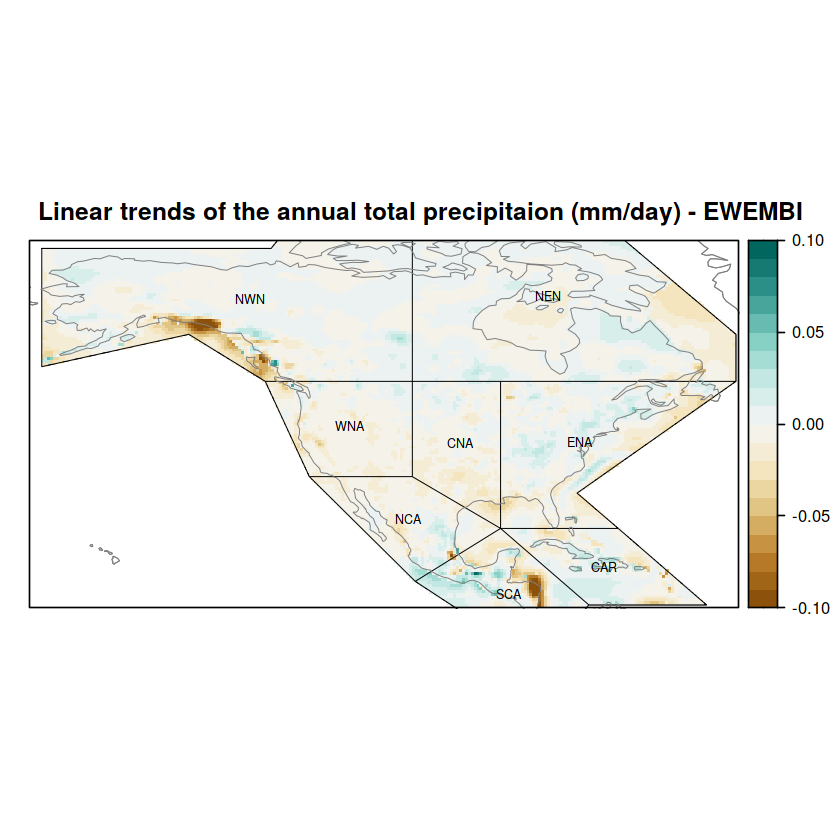

In [13]:
spatialPlot(regsGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitaion (mm/day) - EWEMBI"),
            sp.layout = list(  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

We repeat the process but to the obtain the p-values of the linear trends. Therefore we subset the variable `"pval"`using `subsetGrid`. Then we mask the p-values over the IPCC regions using function `overGrid`. But previously we build an artificial land-sea mask to avoid R misuses with NaN data over the sea when calculating the p-values.

In [14]:
mask <- binaryGrid(climatology(grid),condition = "GE", threshold = 0, values = c(NA,1))
pvalGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "pval") %>% gridArithmetics(mask) 
pvalGrid <- overGrid(pvalGrid, regs[regs.area])

[2021-07-09 11:53:04] - Computing climatology...
[2021-07-09 11:53:05] - Done.
The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.
[2021-07-09 11:53:05] - Computing climatology...
[2021-07-09 11:53:05] - Done.
Warning message:
“Only one grid passed as input. Nothing was done”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”

We use the p-values computed above to perform hatching over the future spatial maps. To do so, we capsulate the function `map.hatching` in a 2-way loop that corresponds to each line in a 'x' symbol. An 'x' would be associated whenever the condition is fullfilled, in our casem whenever the p-value is greater than 0.1. The `aggr.fun` indicates how to treat/aggregate the information contained in adjacent spatial gridpoints when upscaling is done.

In [15]:
aggr.fun <- function(x) {
    xx <- length(which(!is.na(x)))/length(x) * 100
    if (as.numeric(xx >= 75)) 0 else NA
}
l <- lapply(c("45","-45"), FUN = function(z) {
    c(map.hatching(clim = climatology(pvalGrid), 
                   threshold = 0.1, 
                   condition = "GT", 
                   density = 6,
                   angle = z, coverage.percent = 50,
                   upscaling.aggr.fun = list(FUN = aggr.fun)), 
    "which" = 1, lwd = 0.6)
})

[2021-07-09 11:53:13] - Computing climatology...
[2021-07-09 11:53:13] - Done.
[2021-07-09 11:53:14] - Computing climatology...
[2021-07-09 11:53:14] - Done.


We rely on `spatialPlot` from visualizeR, to depict the trend maps and include the p-value as hatching as a member of the `sp.layout` list.

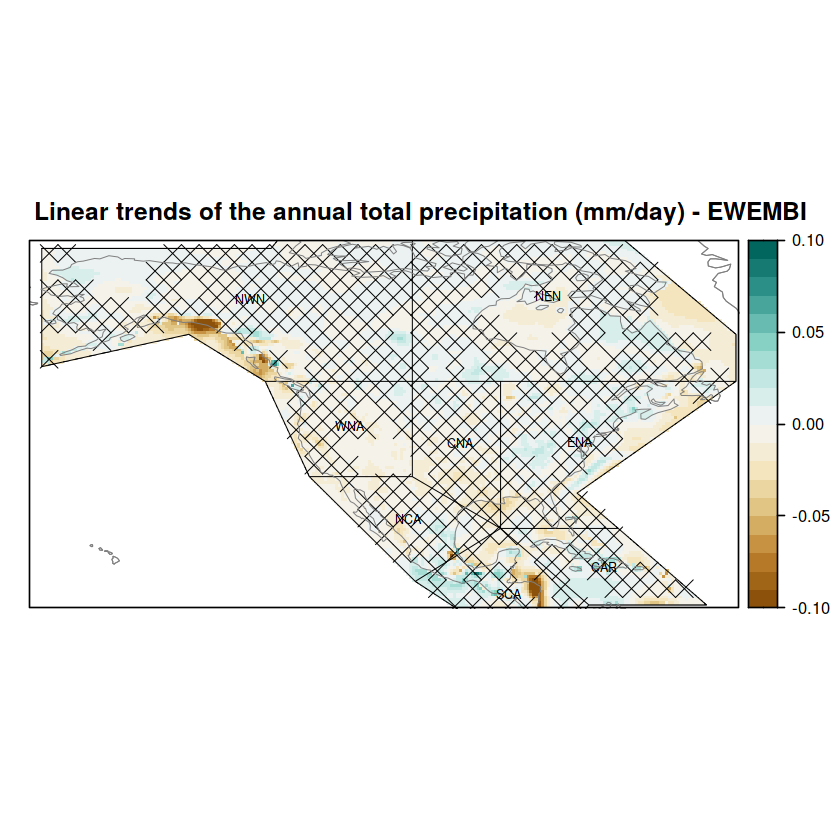

In [16]:
spatialPlot(regsGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitation (mm/day) - EWEMBI"),
            sp.layout = list(
            l[[1]],l[[2]],  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

We loop over the IPCC regions to generate as many members as regions containing the temporal series. This would facilitate to obtain spatial averages over each region since their information has been splitted in members over an `R` list. To do so we rely on function `overGrid`.

In [17]:
grid.regs <- lapply(regs.area, function(r) overGrid(grid, regs[r]))
names(grid.regs) <- regs.area

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded da

We compute the anomalies by calling `scaleGrid` of `transformeR` and setting the argument `type = center` to substract the mean to the temporal series. Previously, we call `aggregateGrid` over the list of IPCC objets to average over each region and therefore output the temporal series for every North American IPCC region.

In [18]:
grid.anom <- lapply(grid.regs, function(x) {
    aggregateGrid(x, aggr.lat = list(FUN = "mean", na.rm = TRUE), aggr.lon = list(FUN = "mean", na.rm = TRUE))
} %>% scaleGrid(type = "center"))  

[2021-07-09 11:53:21] - Scaling ...
Calculating areal weights...
[2021-07-09 11:53:21] - Aggregating lat dimension...
[2021-07-09 11:53:21] - Done.
[2021-07-09 11:53:21] - Aggregating lon dimension...
[2021-07-09 11:53:21] - Done.
[2021-07-09 11:53:21] - Done
[2021-07-09 11:53:21] - Scaling ...
Calculating areal weights...
[2021-07-09 11:53:21] - Aggregating lat dimension...
[2021-07-09 11:53:21] - Done.
[2021-07-09 11:53:21] - Aggregating lon dimension...
[2021-07-09 11:53:21] - Done.
[2021-07-09 11:53:21] - Done
[2021-07-09 11:53:21] - Scaling ...
Calculating areal weights...
[2021-07-09 11:53:21] - Aggregating lat dimension...
[2021-07-09 11:53:22] - Done.
[2021-07-09 11:53:22] - Aggregating lon dimension...
[2021-07-09 11:53:22] - Done.
[2021-07-09 11:53:22] - Done
[2021-07-09 11:53:22] - Scaling ...
Calculating areal weights...
[2021-07-09 11:53:22] - Aggregating lat dimension...
[2021-07-09 11:53:22] - Done.
[2021-07-09 11:53:22] - Aggregating lon dimension...
[2021-07-09 11:53:2

Finally, we call `temporalPlot` of library `visualizeR` to depict the resulting anomaly time series.

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.
[2021-07-09 11:53:22] - Computing climatology...
[2021-07-09 11:53:22] - Done.
Warning message:
“Only one grid passed as input. Nothing was done”pad applied on the interval: year
The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.
[2021-07-09 11:53:23] - Computing climatology...
[2021-07-09 11:53:23] - Done.
Warning message:
“Only one grid passed as input. Nothing was done”pad applied on the interval: year
The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to

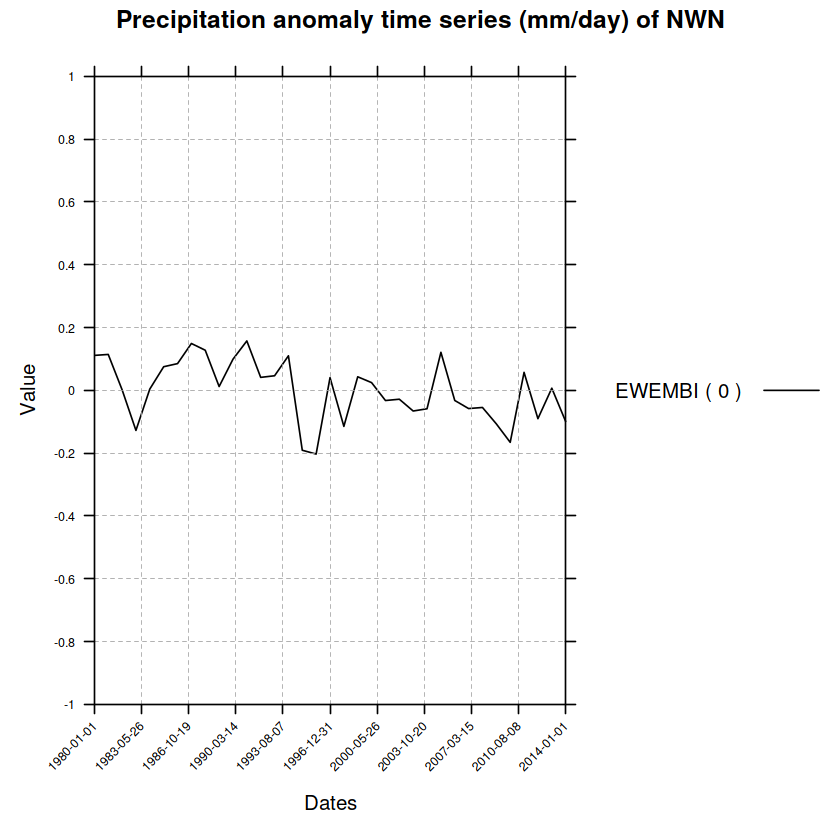

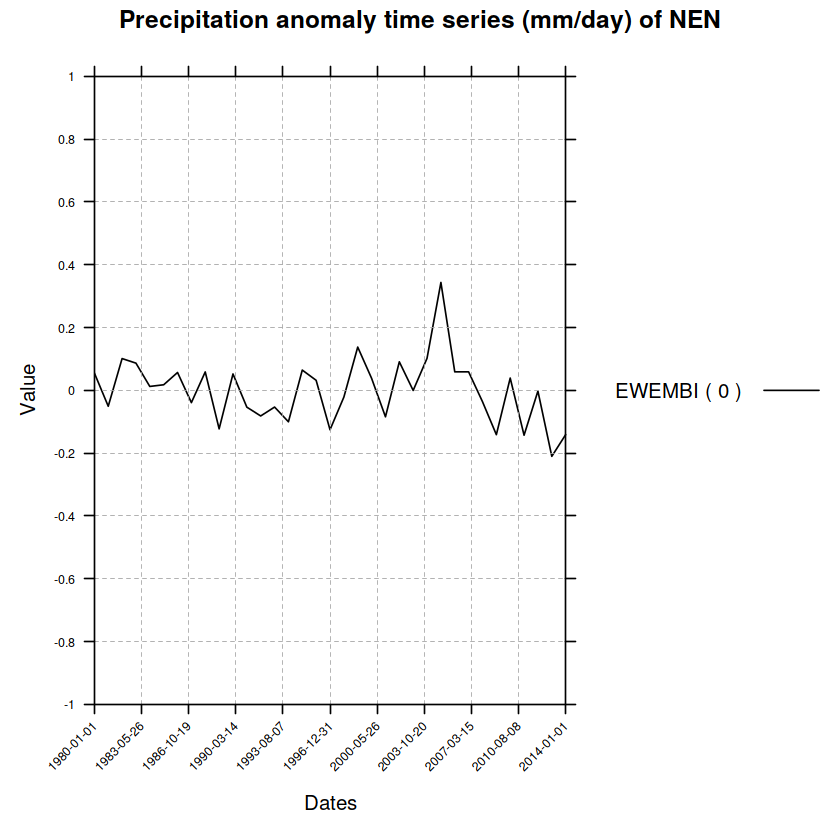

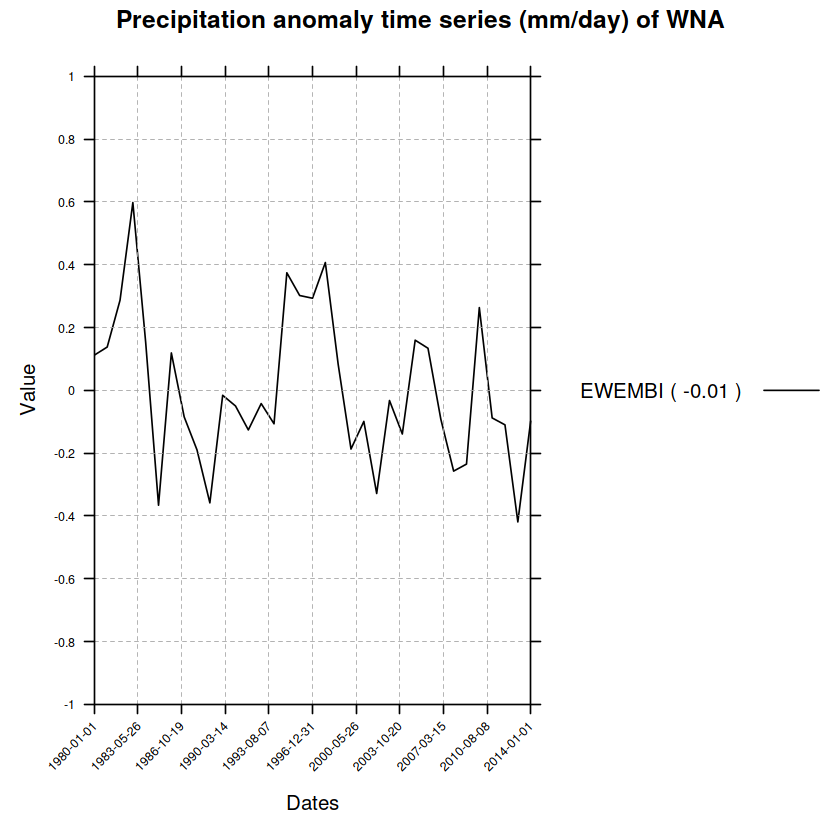

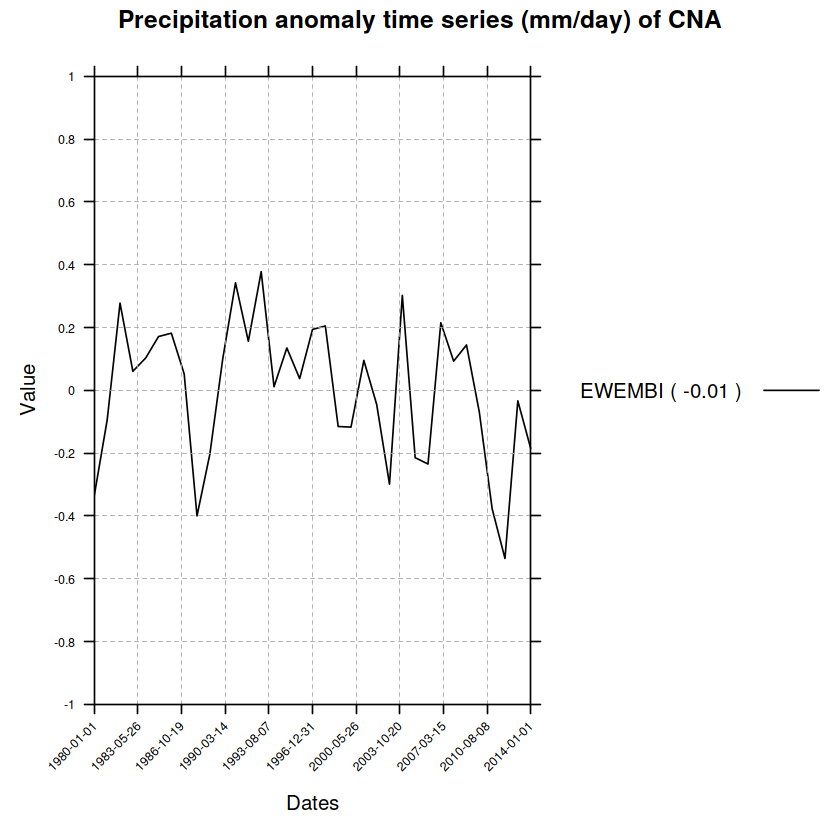

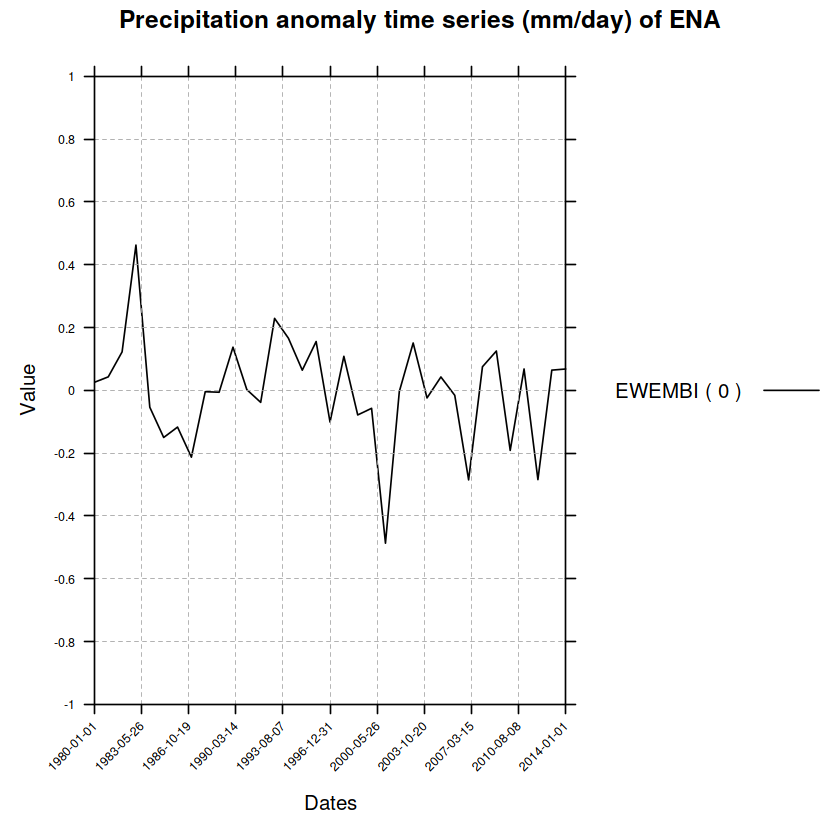

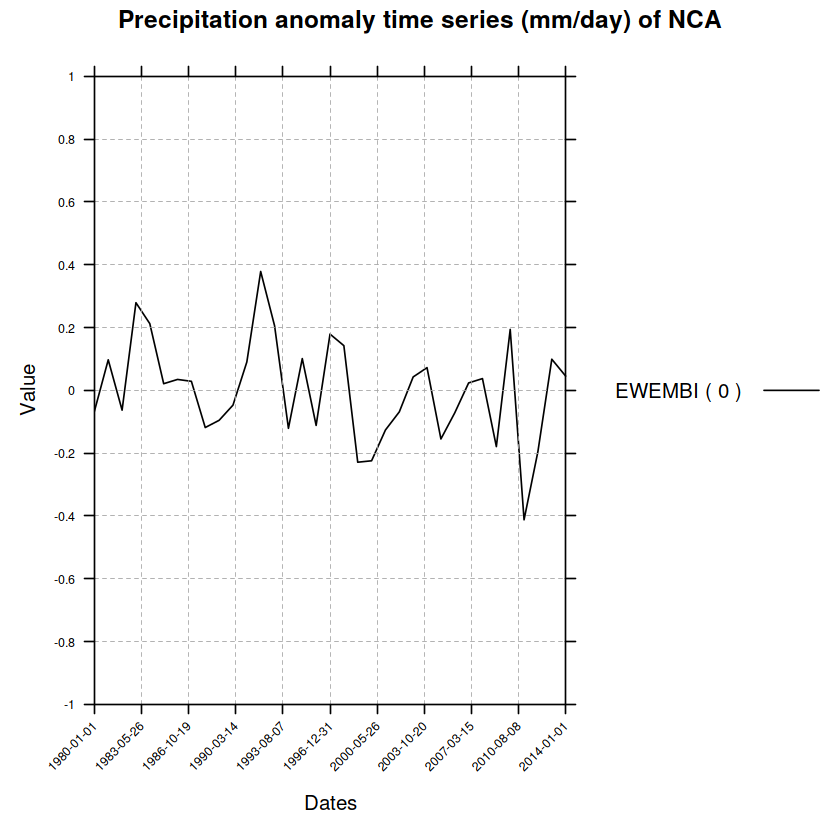

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


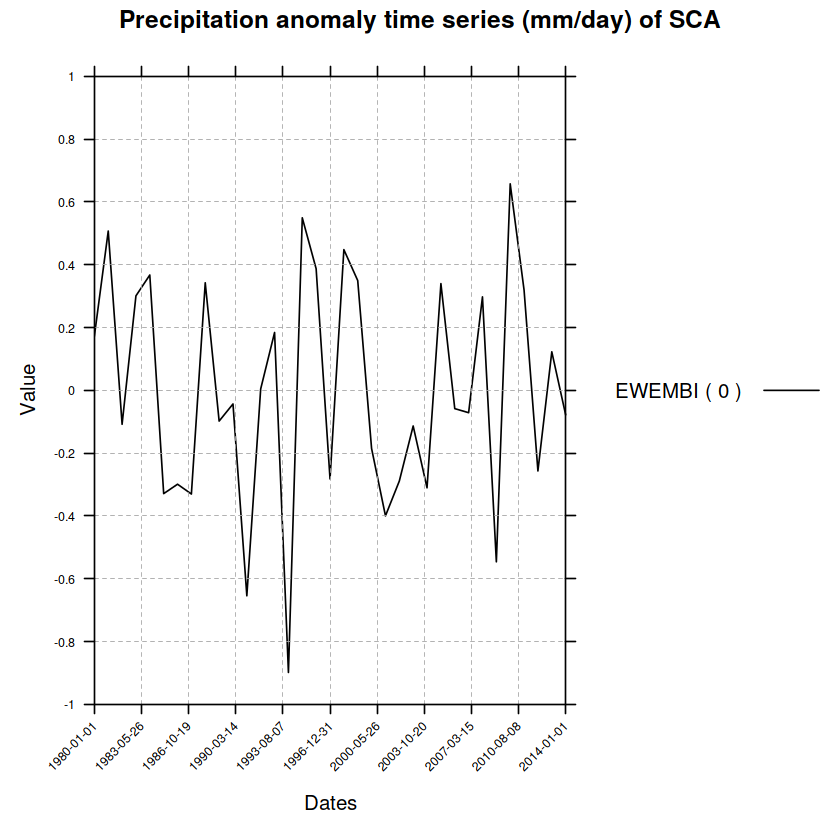

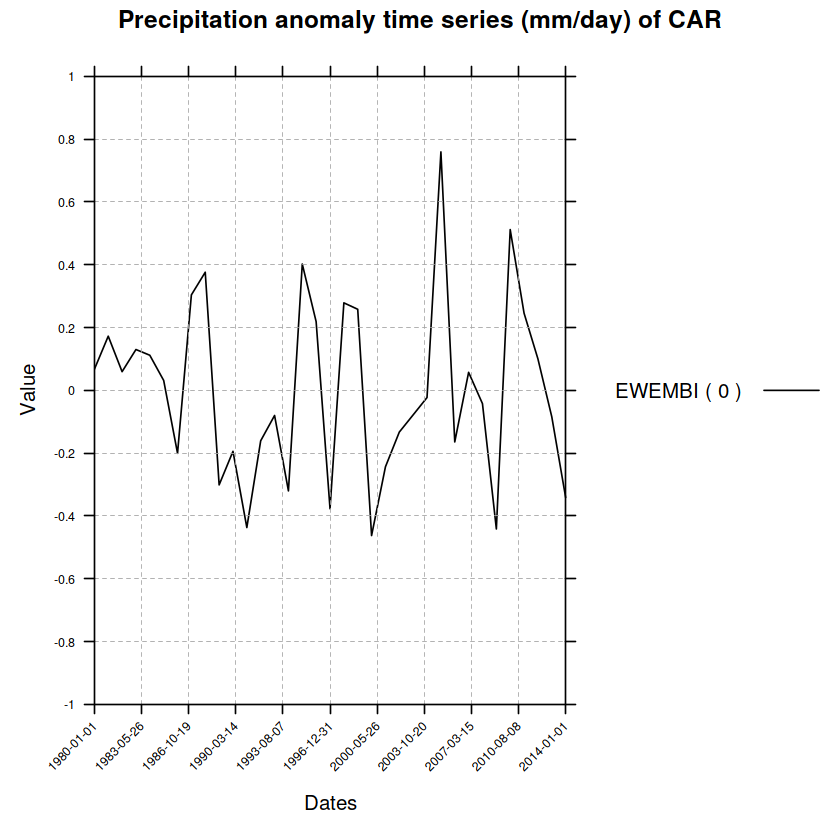

In [19]:
lapply(1:length(grid.anom), FUN = function(x) {
  aux <- (linearTrend(grid.anom[[x]], p = 0.9) %>% subsetGrid(var = "b"))$Data[1]
  
  key.trans <- list(space="right",
                    text=list(c(paste("EWEMBI","(",round(aux,digits=2),")"))),
                    lines=list(col=c("black"), lty = c(1)))                
  temporalPlot(grid.anom[[x]],
               xyplot.custom = list(
                 main = paste("Precipitation anomaly time series (mm/day) of",regs.area[x]),
                 ylim = ylim_anom,
                 key = key.trans   
               ))
})                

### Session info

In [20]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/chus/usr/miniconda3/envs/c4r/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            RColorBrewer_1.1-2      sp_1.4-5               
 [4] magrittr_2.0.1          climate4R.indices_0.2.0 geoprocessoR_0.2.0     
 [7] visualizeR_1.6.0        transformeR_2.1.0       loadeR_1.7.0           
[10] climate4R.UDG_0.2.0     loadeR.ja